# Basis Expansions and Regularization

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import math
from ipywidgets import interact, interact_manual

## Piecewise Polynomials and Splines 

### Example Figure 5.2 and Equotian 5.3

In [2]:
## lets generate an imputvariable stored in x
x = np.arange(0,10,0.1)
y = np.sin(x) 
yNoise = y + np.random.normal(0,0.2,len(x))

In [3]:
## define function for cubic spline

def cubicSpline(X,ne1,ne2):
    """compute set of basis functions (cubic spline) for input X
    and nodes ne1,ne2
    
    Parameters
    ----------
    X : ndarray(1,N)  
        Input X
    ne1 : int
        index of knot 1 in X
    ne2 : int
        index of knot 2 in X      
        
    Return
    -------
    basis : ndarray(M,len(X))
        matrix that contains the basis expansions for Input X with M basis functions
    """
    e1 = X[ne1]
    e2 = X[ne2]
    # create basis functions
    M = 6 # number of bases (4+2 knots)
    basis = np.zeros((M,len(X)))
    basis[0,:] = np.ones(len(X))
    basis[1,:] = X
    basis[2,:] = X**2
    basis[3,:] = X**3
    basis[4,ne1:] = (X[ne1:]-e1)**3
    basis[5,ne2:] = (X[ne2:]-e2)**3
    
    return basis  

def getB(model,y):
    """compute coefficents b for model via least squares
    
    Parameters
    ----------
    model : ndarray(M,len(x))
        basis expansions
    y : ndarray(1,len(x))
        f(x)      
    Return
    -------
    b : ndarray(M,1)
        coefficients
    """
    b = np.dot(np.dot(np.linalg.inv(np.dot(model,model.T)),model),y)
    return b 

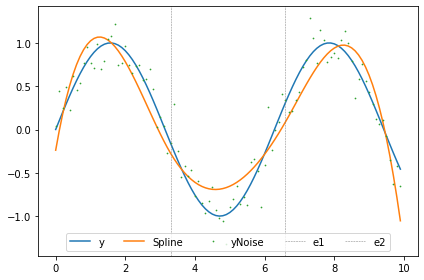

In [4]:
## recreate spline from example (cubic and continous)
# Page 143, Figure 5.3

# calculate splines
# nodes 
ne1 = 33 # number in time array
ne2 = 66

H = cubicSpline(x,ne1,ne2)
b = getB(H,yNoise)

# f(x) = b.T * h
spline = b.reshape(len(b),1) *  H
spline = sum(spline,0)

# plot
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(x,y)
ax1.plot(x,spline)
ax1.plot(x,yNoise,'o',markersize = 0.7)
ax1.axvline(x[ne1],ls = '--', lw = .5, color = 'C7')
ax1.axvline(x[ne2],ls = '--', lw = .5, color = 'C7')
ax1.legend(['y','Spline','yNoise','e1','e2'], loc = 'lower center', ncol = 6)
plt.tight_layout()
plt.show()



Text(0, 0.5, 'Pointwise Variance')

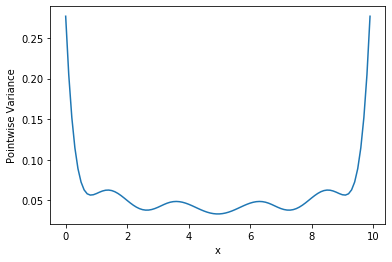

In [5]:
## Pointwise Variance Cov(β^)=σ2(Z′Z)−1

covB = np.linalg.inv(np.dot(H,H.T))

var = np.zeros(len(x))

for i in range(0,len(x)):
    var[i] = np.dot(np.dot(H[:,i],covB),H[:,i].T)

plt.plot(x,var)
plt.xlabel('x')
plt.ylabel('Pointwise Variance')

In [6]:
## interactive part - get a feeling for placement of knots

@interact
def show_articles_more_than(n1=(0, 99, 1), n2=(0, 99, 1)):
    H = cubicSpline(x,n1,n2)
    b = getB(H,yNoise)
    fx = b.reshape(len(b),1) * H
    fx = sum(fx,0)
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(x,y)
    ax2.plot(x,fx)
    ax2.plot(x,yNoise,'o',markersize = 0.7)
    ax2.axvline(x[n1],ls = '--', lw = .5, color = 'C7')
    ax2.axvline(x[n2],ls = '--', lw = .5, color = 'C7')
        
    return 


interactive(children=(IntSlider(value=49, description='n1', max=99), IntSlider(value=49, description='n2', max…

In [7]:
def cubicSpline2(X,k):
    """compute cubic spline for input X
    and nodes ne
    
    Parameters
    ----------
    X : ndarray(1,N)  
        Input X
    k : int
        number of knots 
        
    Return
    -------
    basis : ndarray(M,len(X))
        matrix that contains the basis expansions for Input X with M basis functions
    """
    interval = len(X)/(k+1)

    # create basis functions
    M = 4 + k 
    basis = np.zeros((M,len(X)))
    basis[0,:] = np.ones(len(X))
    basis[1,:] = X
    basis[2,:] = X**2
    basis[3,:] = X**3
    for i in range(1,k+1):
        nek = int(round(i*(interval),0))
        basis[3+i,nek:] = (X[nek:]-X[nek])**3
    return basis  

def getB(model,y):
    """compute coefficents b for model via least squares
    
    Parameters
    ----------
    model : ndarray(M,len(x))
        basis expansions
    y : ndarray(1,len(x))
        f(x)      
    Return
    -------
    b : ndarray(M,1)
        coefficients
    """
    b = np.dot(np.dot(np.linalg.inv(np.dot(model,model.T)),model),y)
    return b 
                         

In [8]:
## interactive part - get a feeling for number of knots

@interact
def show_articles_more_than(n=(0, 20, 1)):
    H = cubicSpline2(x,n)
    b = getB(H,yNoise)
    fx = b.reshape(len(b),1) * H
    fx = sum(fx,0)
    
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    ax3.plot(x,y)
    ax3.plot(x,fx)
    ax3.plot(x,yNoise,'o',markersize = 0.7)
    
    dx = ((len(x))/(n+1))
    for i in range(1,n+1):
        nk = int(round(i*dx,0))
        ax3.axvline(x[nk],ls = '--', lw = .5, color = 'C7')
    return 


interactive(children=(IntSlider(value=10, description='n', max=20), Output()), _dom_classes=('widget-interact'…

## Natrual Splines

In [9]:
## define functions

def getDK(X,nek,neK):
    """compute natural cubic spline for input X
    and nodes n
    
    Parameters
    ----------
    X : ndarray(1,N)  
        Input X
    nek : int
        index knot k
    neK : int
        index knot K (boundaray knot) 
        
    Return
    -------
    dk : ndarray(2+n,len(X))
        matrix that contains the basis expansions for Input X with 2+nbasis functions
    """
    
    dK = np.zeros(len(X))
    basis = np.zeros([2,len(X)])
    basis[0,X>nek] = (X[X>nek]-nek)**3 
    basis[1,X>neK] = (X[X>neK]-neK)**3 
    
    dK = (basis[0,:] - basis [1,:]) / (neK - nek)
    return dK
    
def natCubicSpline(X,knots):
    """compute natural cubic spline for input X
    and nodes n
    
    Parameters
    ----------
    X : ndarray(1,N)  
        Input X
    knots : int
        number of knots    
        
    Return
    -------
    matBasis : ndarray(2+n,len(X))
        matrix that contains the basis expansions for Input X with 2+nbasis functions
    """
    # create basis functions
    matBasis = np.zeros((knots,len(X)))
    matBasis[0,:] = np.ones(len(X))
    matBasis[1,:] = X
    
    
    dx = ((max(X))/(knots+1)) #interval length
    
    # dk-1
    neK1 = (knots-1)*dx
    neK = knots*dx
    dK1 = getDK(X,neK1,neK)

    for k in range(1,knots-1):
        nek = k*dx
        dk = getDK(X,nek,neK)
        matBasis[1+k,:] = dk - dK1
    return matBasis
    

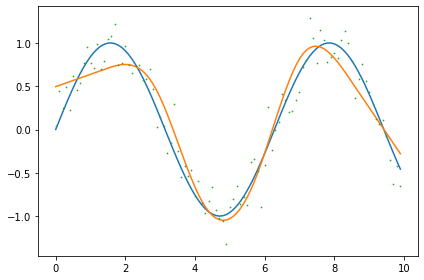

In [10]:
natSpline = natCubicSpline(x,6)
b = getB(natSpline,yNoise)
# f(x) = b.T * h
fx = b.reshape(len(b),1) * natSpline
fx = sum(fx,0)

# plot
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(x,y)
ax4.plot(x,fx)
ax4.plot(x,yNoise,'o',markersize = 0.7)
plt.tight_layout()
plt.show()

In [11]:
## interactive part - get a feeling for number of knots in natural cubic splines

@interact
def show_articles_more_than(n=(2, 20, 1)):
    H = natCubicSpline(x,n)
    b = getB(H,yNoise)
    fx = b.reshape(len(b),1) * H
    fx = sum(fx,0)
    
    fig5 = plt.figure()
    ax5 = fig5.add_subplot(111)
    ax5.plot(x,y)
    ax5.plot(x,fx)
    ax5.plot(x,yNoise,'o',markersize = 0.7)
    dx = ((len(x))/(n+1))
    for i in range(1,n+1):
        nk = int(round(i*dx,0))
        ax5.axvline(x[nk],ls = '--', lw = .5, color = 'C7')
    return 

interactive(children=(IntSlider(value=11, description='n', max=20, min=2), Output()), _dom_classes=('widget-in…

## Pointwise Variance

$Var[f(x_0)] = H(x_0) * cov(β) * H(x_0)$

with: 

$cov(β)= σ^2(H^T*H)^−1$

and $σ^2 = 1 $if we assume the error to be normal distributed

In [12]:
### Pointwise Variance
    
def getPointVar(model):
    """computes the pointwise variance for given model
    
    Parameters
    ----------
    model : ndarray(p,N)  
        basis functions   
        
    Return
    -------
    var : ndarray(1,N)
        pointwise variance for each observation
    """
    covB = np.linalg.inv(np.dot(model,model.T)) #covariance via least squares, sigma = 1
    var = np.zeros(len(x))
    for i in range(0,len(x)):
        var[i] = np.dot(np.dot(model[:,i],covB),model[:,i].T)
    return var

Text(0, 0.5, 'Pointwise Variance')

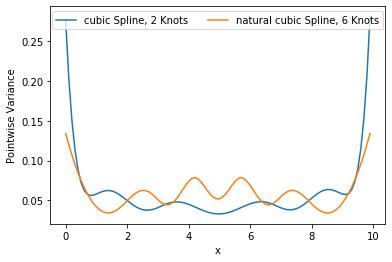

In [26]:
## plot pointwise variances

cubicSpline = cubicSpline2(x,2) 
natCubSpline = natCubicSpline(x,6)

varCubic = getPointVar(cubicSpline)
varNat = getPointVar(natCubSpline)

fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.plot(x,varCubic)
ax6.plot(x,varNat)
ax6.legend(['cubic Spline, 2 Knots', 'natural cubic Spline, 6 Knots'], loc = 'upper center', ncol = 2)
ax6.set_xlabel('x')
ax6.set_ylabel('Pointwise Variance')


# Filtering and Feature Extraction

## Example: Phoneme Recognition


In [19]:
## Reading and preparing data

phonemData = pd.read_csv('phoneme.csv', index_col='g')
phonemData = phonemData.drop(['speaker'], axis = 1)
phonemData = phonemData.drop(['row.names'], axis = 1)
phonemData = phonemData.T

x = phonemData[['aa','ao']].to_numpy()
yList = list(phonemData[['aa','ao']].columns.values) 
y = np.zeros(len(yList))

for i in range(0,len(y)):
    if yList[i] == 'ao':
        y[i] = 0
    else:
        y[i] = 1

## natural cubic splines with 12 knots uniformly distributed over frequency vector
f = np.arange(0,256)
H = natCubicSpline(f,12).T

## Filter data
xFiltered = np.dot(H.T,x)

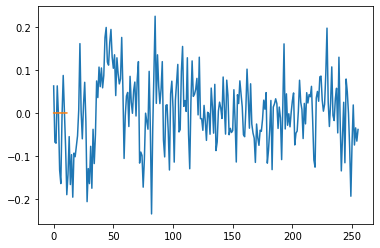

In [25]:
## Logistig Regression
from sklearn import linear_model

logReg = linear_model.LogisticRegression(random_state=0)

logReg.fit(x.T,y)

params = logReg.get_params()
coeffs = logReg.coef_
plt.plot(coeffs.T)

logRegFilter = linear_model.LogisticRegression(random_state=0)

logRegFilter.fit(xFiltered.T,y)
coeffsFiltered = logRegFilter.coef_
plt.plot(coeffsFiltered.T)